In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import re
from time import sleep

import requests

import tqdm

import itertools

import json

from bs4 import BeautifulSoup

Code for parsing news. Relativly fast, dataset can be recrated in about 15 minutes with stable 
internet conection and without obstacles from anti-crawler scripts on seekningalpha.com

In [2]:
# failedi = []
# with open('seekingalpha_topnews_middle', 'a') as f:
#     with requests.Session() as s:
#         for i in tqdm.tqdm_notebook(range(235)):
#             sleep(np.random.rand() * 2.)
#             r = requests.Request(method='GET', 
#                                  url='https://seekingalpha.com/market-news/top-news', 
#                                  headers={'user-agent':'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36'},
#                                  params={'page':i})
#             req = r.prepare()
#             try:
#                 back = s.send(req, timeout=3)
#             except TimeoutError:
#                 failedi.append(i)
#                 continue
                
#             if(back.status_code == 200):
#                 print("Success {}".format(i))
#                 f.write(back.text)
#             else:
#                 print('Failed with code {}'.format(back.status_code))
#                 failedi.append(i)

Parsing resulted raw html and constructing pandas dataframe

In [3]:
with open('seekingalpha_topnews', 'r') as file:
    lines = [line.rstrip('\n') for line in file]

# create an insance of BeautifulSoup class for easy html parsing
soup = BeautifulSoup(''.join(lines), 'html.parser')

news_list = []

# all information that we need is inside <ul class='mc-list'> tags
for block in tqdm.tqdm_notebook(soup.find_all(name='ul', attrs={'class':'mc-list'})):
    
    # each bullet point <li> contains either date or news
    for li in block.children:
        
        # if we encountered 'date-title' it means that the following news 
        # until next 'date-title' are from that date
        if(li.attrs['class'] == ['date-title']):
            date = li.contents[0]
            continue
            
        # if class of <li> tag is 'mc', we encountered block with news 
        # (a short info and link to one article)
        if(li.attrs['class'] == ['mc']):
            symbol = li.contents[0].find(name='a')
            if(symbol is not None):
                symbol = symbol.contents[0]
            title = li.contents[1].find(name='div', attrs={'class':'title'})
            if(title is not None):
                title = title.find(name='a')
                if(title is not None):
                    link = 'https://seekingalpha.com' + title.attrs['href']
                    title = title.contents[0]
            content = li.contents[1].find(name='div', attrs={'class':'bullets'})
            bullets = []
            if(content is not None):
                # from the middle of 2013 seeking alpha changed its formatting to 
                # actual bullet points, rather than just summary. So lets utilize it
                bullet_points = content.find_all(name='li')
                if((bullet_points is not None) and (len(bullet_points) > 0)):
                    for bullet in bullet_points:
                        bullets.append(bullet.text.replace('\xa0', ' '))
                else: # before the middle of 2013 there is no <li> tags in bullets div container
                    bullets.append(content.text.replace('\xa0', ' '))
                    
            number_of_comments = li.contents[1].find(name='span', attrs={'class':'comments-n'})
            if (number_of_comments is not None):
                number_of_comments = int(re.findall(r'[0-9].', number_of_comments.text.replace('\xa0', ' '))[0])

            time = li.contents[1].find(name='span', attrs={'class':'item-date'})
            if (time is not None):
                time = time.text.replace('\xa0', ' ')
            else:
                time = ''

            news_list.append(pd.DataFrame({'date':time + ', ' + date, 
                                           'symbol':symbol, 
                                           'title':title, 
                                           'link':link, 
                                           'bullets':'\n'.join(bullets), 
                                           'comments':number_of_comments}, index=[0]))

# concat dataframe from list
news = pd.concat(news_list, ignore_index=True)

# transform data from string to DateTime
news['date'] = pd.to_datetime(news['date'])

# reorder columns. Just for aesthetics :)
news = news[['date', 'symbol', 'title', 'link', 'bullets', 'comments']]

# if for some reason we downloaded some news more than once, lets drop them
news = news.drop_duplicates()

# save to csv
news.to_csv('seekingalpha_top.csv')


# dataframe reads from csv file without any fancy parameters
# news = pd.read_csv('seekingalpha_top.csv')

Widget Javascript not detected.  It may not be installed or enabled properly.


Most of dataframes' column names are self explanatory, but let us add some info nonetheless:

1. 'date' - date and time of news article posting. In pandas DateTime format 
2. 'symbol' - a Ticker Symbol (https://www.investopedia.com/terms/t/tickersymbol.asp). Some news do not have a specific associated security - for such news symbol is "None"
3. 'title' - news article titile in string
4. 'link' - a link to the article
5. 'bullets' - a short summary of news article in the form of bullet points. Stored in one python sring, each bullet separated by "\n" character. It may be important to know that until the middle of 2013 seaking alpha did not use the bullet point structure and provided just general summary in one line
6. 'comments' - a number of comments for this article


In [4]:
news.head()

,date,symbol,title,link,bullets,comments
0,2018-04-02 16:50:00,None,S&P closes below 200-day moving average for fi...,https://seekingalpha.com/news/3343148-s-and-p-...,"Stocks started Q2 with broad-based losses, as ...",4
1,2018-04-02 14:51:00,QQQ,"Nasdaq plunges 3.5%, goes into the red for the...",https://seekingalpha.com/news/3343081-nasdaq-p...,"The Dow, S&P 500, and Russell 2000 were alread...",70
2,2018-04-02 12:48:00,GLD,"Little bid for bonds as stocks dive, but gold ...",https://seekingalpha.com/news/3343041-little-b...,The major averages are all lower by more than ...,3
3,2018-04-02 11:47:00,DIS,ESPN Plus to debut April 12 at $4.99/month,https://seekingalpha.com/news/3343012-espn-plu...,"ESPN Plus will debut in 10 days, on April 12, ...",36
4,2018-04-02 10:25:00,None,Averages under pressure to start the quarter,https://seekingalpha.com/news/3342979-averages...,Leading early declines are Amazon (-3.8%) afte...,50


You can see that starting from the middle of 2013, 'bullets' become about twice longer

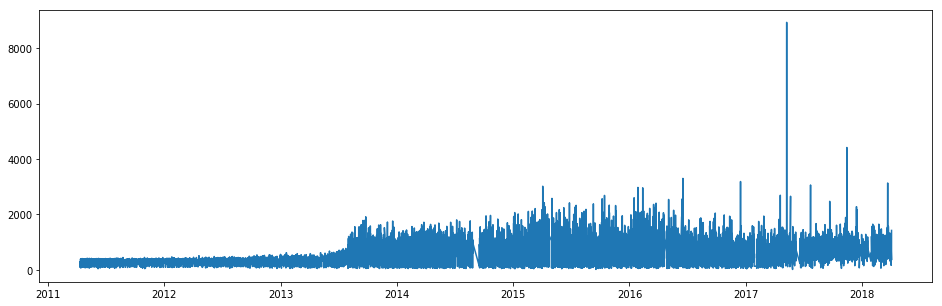

In [5]:
plt.figure(figsize=(16, 5))
plt.plot(news.date, news.bullets.apply(len));

The lenght of news titles changed through time - before the middle of 2013 title usualy were just first 100 characters from the article

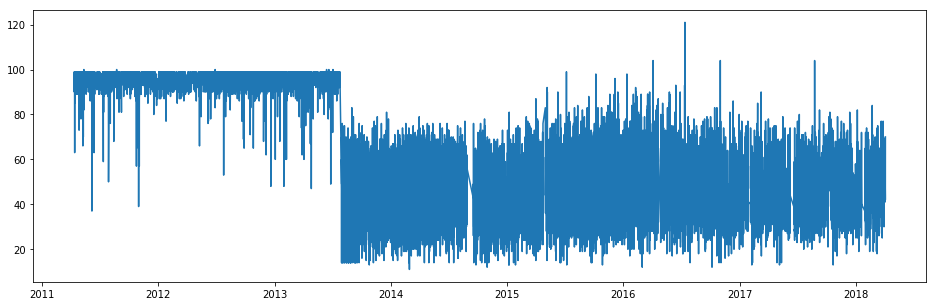

In [29]:
plt.figure(figsize=(16, 5))
plt.plot(news.date, news.title.apply(len));

In [6]:
# Some stats of constructed dataset:

print('There are {} news articles'.format(len(news)))
print('Timewise, we have news from {} to {}'.format(min(news.date), max(news.date)))

There are 17202 news articles
Timewise, we have news from 2011-04-11 16:10:00 to 2018-04-02 16:50:00


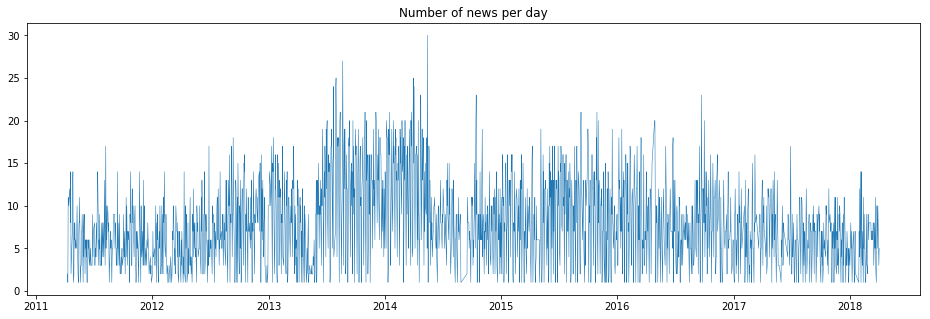

In [7]:
news.date.dt.date.value_counts().plot(linewidth=0.5, figsize=(16, 5), title='Number of news per day');

The number of comments for each article roughtly follows exponential distribution:

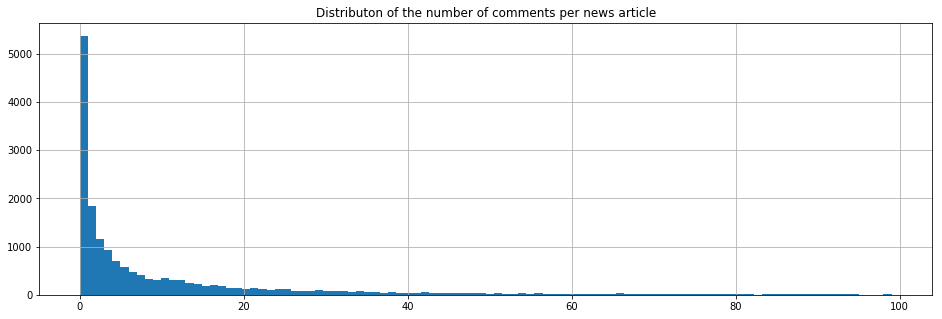

In [8]:
c = news.comments.fillna(0)
plt.figure(figsize=(16, 5));
c.hist(bins=len(np.unique(c)));
plt.title('Distributon of the number of comments per news article');

There are a lot of tick symbols, mentioned in the news:

In [31]:
print('Number of unique symbols: {}'.format(len(news.symbol.unique())))
print('Average number of news per symbol: {}'.format(np.mean(news.symbol.value_counts())))

Number of unique symbols: 1180
Average number of news per symbol: 9.297709923664122


Top symbols are a collection of ETF funds and popular companies (AAPL - Apple, T - AT&T, GOOG - Google, MSFT - Microsoft, FB - Facebook, ...):

In [32]:
news.symbol.value_counts()[:15]

SPY     926
FXI     416
USO     363
FXE     339
AAPL    327
TLT     205
T       193
DXJ     183
GOOG    171
DIS     141
GREK    135
FXB     126
MSFT    114
VZ      112
FB      112
Name: symbol, dtype: int64

parsing comments is a little bit tricky - they are open only for registered users. So we have to create an account and specify given cookie information. If you were to repeat parsing comments, prepare to wait for at least several hours 

In [9]:
# failed_url = []

# my_cookie = {'__gads':'ID=3e55728b75144f34:T=1522617530:S=ALNI_MaGA28To_riRwevWjj_opRDAj8J0Q',
#              '__utma':'150447540.550161069.1522617530.1523472444.1523525599.19',
#              '__utmb':'150447540.44.8.1523534950876',
#              '__utmc':'150447540',
#              '__utmt':'1',
#               '__utmz':'150447540.1522673540.4.3.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided)',
#              '_dm_sync':'true',
#              '_ig':'48e6a661-c5cb-4616-d1e5-6cad52024e2b',
#              '_igg':'yJZIZBsIDJlvLUO6fcS5',
#              '_igt':'62b0204b-e655-4112-884d-c92644c5e614',
#              '_px':'jDsSIvgNr3T1Md94CkjC+0YPz+N6sqJ/cuC3ytG3mB5qupLsmVO3/N3KcUjtd4GeOOImMCdMRPaVIipg6KKOwQ==:1000:slo6b+R7ipb29zkMPrNB3DYLYLdawCkzeBJGH6+VbRSpd+dsWRXrCC4LsseLL20ThprylamGfP9nH1Fx1zeU1WDsJUM3k2F7YMN8UC1oTedyzJczpIrb8b5ERtO+GCT5mDu/hx4vLjac7fQJ9iNStE2LPpJ27t00RTZOXWBsSi7LKEBhDmALpXlxNtp2Vz3s/Ch/tmLOuq4ob8jJ4Y4RmB57tnx2W7u7t7VyDXs3TOA1uyfDHlglgkyVIYRyT5F++S7sy5v/m2y39wf2PJ1V3w==',
#              '_px2':'eyJ1IjoiODM0MWNkZjAtM2U0YS0xMWU4LWE3NDUtMmY5NTkxZmExNzUzIiwidiI6IjQ3MGUyZmYwLTM1ZjItMTFlOC1hZjVlLTQxOWJiNWM1MWU0ZiIsInQiOjE1MjM1MzU1MzkxMDQsImgiOiIzMzUzYWEzNmVkMGY0MDgyOWE0YmQyZjA2NDY1ZDA0YWQ5YzAzNmI4ZjM4Y2FlMTlkMzAzNTIyMDJhZTFhYjM2In0=',
#              '_pxff_tm':'1',
#              '_pxvid':'470e2ff0-35f2-11e8-af5e-419bb5c51e4f',
#              'a_t':'1f3bku%3A1dcuj4k%3A92bfc8f54374f8d82b2029abfa4938ab',
#              'free_article':'0',
#              'gk_user_access':'1**1523534996',
#              'gk_user_access_sign':'7137b40ab6541d8980160d6a2fe80baa559302d8',
#              'machine_cookie':'6320973464421',
#              'marketplace_author_slugs':'',
#              'ptac':'',
#              'regsteps':'vocation%2Cnewsletters%2Cstocks',
#              'sapu':'101',
#              'trc_cookie_storage':'taboola%2520global%253Auser-id%3D9544d16a-492f-4df2-81af-6fe0f1e8ab2a',
#              'u_voc':'45%2C80',
#              'url_source_before_register':'https%3A%2F%2Fseekingalpha.com%2F',
#              'user_cookie_key':'cbbd6dcb201fc90efcbb937832b61a6cd198ff2f',
#              'user_devices':'',
#              'user_id':'49393310',
#              'user_nick':'mr.smith79',
#              'user_remember_token':'ee04134fffe38680fe9cd29f487ca874d492b26d'}

# my_cookie = requests.utils.cookiejar_from_dict(my_cookie)

# with open('comments_top_raw_middle', 'a') as f:
#     with requests.Session() as s:
#         for url in tqdm.tqdm_notebook(news.link[6605:13200]):
#             sleep(np.random.rand())
#             r = requests.Request(method='GET', 
#                                  url=url, 
#                                  headers={'user-agent':'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36'},
#                                  cookies=my_cookie)
#             req = r.prepare()

#             try:
#                 back = s.send(req)
#             except TimeoutError:
#                 failed_url.append(url)
#                 continue

#             ID = re.findall(r'[0-9]{5,10}', url)
#             r = requests.Request(method='GET', 
#                                  url='https://seekingalpha.com//account/ajax_get_comments', 
#                                  headers={'user-agent':'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36'},
#                                  cookies=my_cookie,
#                                  params={'id':ID, 'type':'MarketCurrent'})

#             r.headers['referer'] = url
#             r.headers['x-requested-with'] = 'XMLHttpRequest'

#             req = r.prepare()

#             try:
#                 back = s.send(req)
#             except TimeoutError:
#                 failed_url.append(url)
#                 continue

#             if (back.status_code != 200):
#                 print(back.status_code)
#                 failed_url.append(url)
#             else:
#                 f.write(url + '\n')
#                 f.write(back.text + '\n')

In [39]:
# Now, comments are return from AJAX request in JSON format. 
# Also, there can be multiple levels of comments(a responce to responce to ... to someones' original comment)
# Thankfully, recursion is a thing:

def parse_comment(comment, url):
    return pd.DataFrame({'article_link':url, 
                         'comment_content':comment['content'], 
                         'author_id':comment['user_id'], 
                         'parent_id':comment['parent_id'], 
                         'children_ids':', '.join(comment['children'].keys()), 
                         'is_premium_author':comment['is_premium_author'], 
                         'likes':comment['likes'],
                         'datetime':pd.to_datetime(comment['created_on'])}, index=[comment['id']])

def parse_batch_of_comments(list_of_comments, url):
    Comments = []
    for comment in list_of_comments:
        Comments.append(parse_comment(comment, url))
        if(len(comment['children']) > 0):
            Comments += parse_batch_of_comments(comment['children'].values(), url)
    
    return Comments

JSON = json.JSONDecoder()

comments_df = []

num_lines = sum(1 for line in open('comments_top_raw', 'r'))

with open('comments_top_raw', 'r') as file:
    for url, jsonstring in tqdm.tqdm_notebook(itertools.zip_longest(*[file]*2), total = int(num_lines / 2)):
        parsed = JSON.decode(jsonstring)
        
        if(parsed['status'] == 'success'):
            if(parsed['total'] > 0):
                comments_df.append(pd.concat(parse_batch_of_comments(parsed['comments'].values(), url)))        

comments_df = pd.concat(comments_df)

Widget Javascript not detected.  It may not be installed or enabled properly.


Due to some mistakes in collecting data, i got two separate files with comments. We will join those and then delete any duplicates

In [40]:
comments_df_middle = []

num_lines = sum(1 for line in open('comments_top_raw_middle', 'r'))

with open('comments_top_raw_middle', 'r') as file:
    for url, jsonstring in tqdm.tqdm_notebook(itertools.zip_longest(*[file]*2), total = int(num_lines / 2)):
        parsed = JSON.decode(jsonstring)
        
        if(parsed['status'] == 'success'):
            if(parsed['total'] > 0):
                comments_df_middle.append(pd.concat(parse_batch_of_comments(parsed['comments'].values(), url)))        

comments_df_middle = pd.concat(comments_df_middle)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [41]:
comments = pd.concat([comments_df, comments_df_middle])
comments = comments.drop_duplicates()

comments.to_csv('seekingalpha_top_comments.csv')

# comments = pd.read_csv('seekingalpha_top_comments.csv')

All columns pretty much are self-explanatory

In [15]:
comments.head()

,article_link,author_id,belongs_to_sa_editor,children_ids,comment_content,datetime,is_premium_author,likes,parent_id
78151310,https://seekingalpha.com/news/3343148-s-and-p-...,386082,False,,Almost made a 70 day low in the S&amp;P 500 ( ...,2018-04-02 21:26:09,False,0,None
78151552,https://seekingalpha.com/news/3343148-s-and-p-...,48830101,False,,“It’s more a political concern regarding Trump...,2018-04-02 21:38:48,False,2,None
78152403,https://seekingalpha.com/news/3343148-s-and-p-...,29918765,False,,With new GAAP accounting for stock valuation i...,2018-04-02 22:49:40,False,1,None
78154915,https://seekingalpha.com/news/3343148-s-and-p-...,6486121,False,"78155719, 78157731, 78159226, 78166717",When Trump came into office he was riding a wa...,2018-04-03 06:47:55,False,4,None
78155719,https://seekingalpha.com/news/3343148-s-and-p-...,25281393,False,,Trumpanomica has barely started. The benefits ...,2018-04-03 12:25:05,False,4,78154915


In [28]:
# some stats:

print('We have {} comments in total'.format(len(comments)))
print('Average comment lenght is {:.2f} characters'.format(np.mean(comments.comment_content.apply(len))))
print('Average number of likes is {:.2f}'.format(np.mean(comments.likes)))
print('There are {} comments without parent (those are direct responces to related article)'.format(np.sum(comments.parent_id.isna())))

We have 250029 comments
Average comment lenght is 266.15 characters
Average number of likes is 2.48
There are 103726 comments without parent (those are direct responces to news article)
